In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
from collections import defaultdict
from scipy.interpolate import make_interp_spline  # for smoothing

In [59]:
def accuracy_plots(log_path, tag, save=True, formats=("pdf", "png")):
    """
    Plots training/validation loss and accuracy curves and saves them for LaTeX.
    
    Args:
        log_path (str): Directory containing `training_metrics.csv` (and optionally `training_metrics.json`).
        tag (str): Identifier for the figure title and filename.
        save (bool): Whether to save the figure in the specified formats.
        formats (tuple): File formats to save (e.g., ("pdf", "png")).
    """
    df = pd.read_csv(os.path.join(log_path, 'training_metrics.csv'))

    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot loss on left y-axis
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', color='tab:red', fontsize=12)
    ax1.plot(df['epoch'], df['train_loss'], color='red', linestyle='-', label='Train Loss', linewidth=2)
    ax1.plot(df['epoch'], df['val_loss'], color='darkred', linestyle='--', label='Val Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, alpha=0.3)
    
    # Create second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:blue', fontsize=12)
    ax2.plot(df['epoch'], df['train_acc'], color='blue', linestyle='-', label='Train Acc', linewidth=2)
    ax2.plot(df['epoch'], df['val_acc'], color='darkblue', linestyle='--', label='Val Acc', linewidth=2)
    
    # Try loading test accuracy from JSON
    try:
        with open(os.path.join(log_path, 'training_metrics.json'), 'r') as f:
            metrics = json.load(f)
        
        if metrics.get('test_acc') is not None:
            test_acc = metrics['test_acc']
            ax2.axhline(
                y=test_acc,
                color='green',
                linestyle=':',
                linewidth=3,
                label=f'Final Test Acc ({test_acc:.2f}%)',
                alpha=0.8
            )
    except (FileNotFoundError, json.JSONDecodeError):
        print("Could not load test accuracy from JSON file")
    
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Oracle: {tag} - Loss and Accuracy', fontsize=14, fontweight='bold', pad=20)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', framealpha=0.9)
    
    fig.tight_layout()

    # Save plots
    if save:
        for fmt in formats:
            out_path = os.path.join(log_path, f"{tag}_accuracy_plot.{fmt}")
            plt.savefig(out_path, format=fmt, bbox_inches="tight")
            print(f"Saved plot to {out_path}")
    
    plt.show()


Saved plot to ../logs/mnist_activation/MNIST_accuracy_plot.pdf
Saved plot to ../logs/mnist_activation/MNIST_accuracy_plot.png


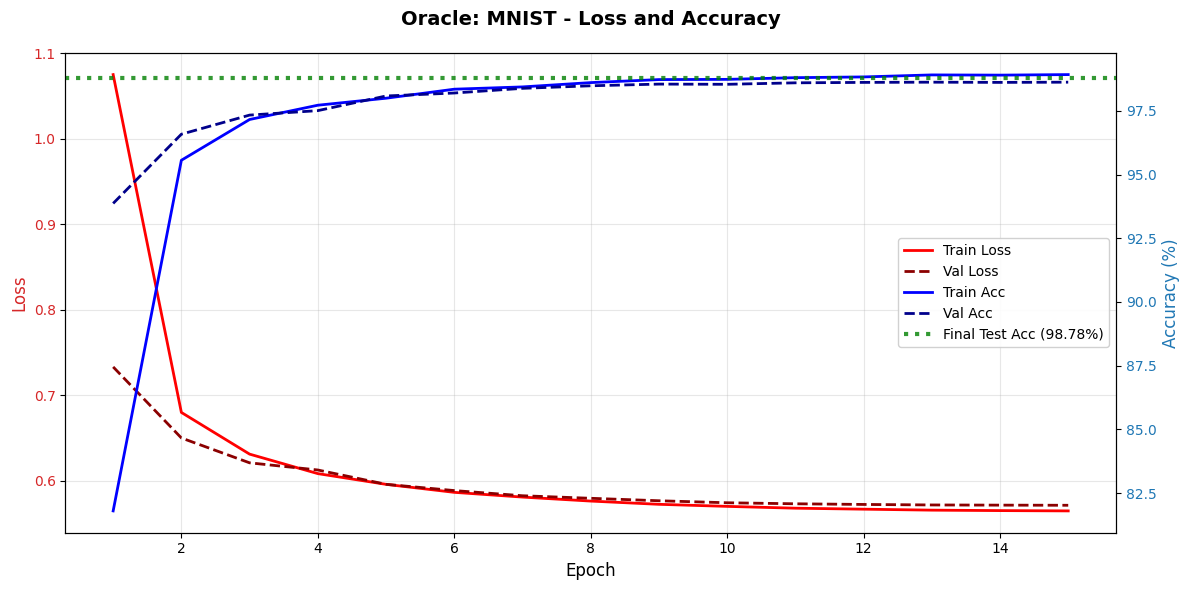

In [60]:
accuracy_plots('../logs/mnist_activation/', "MNIST")

Saved plot to ../logs/cifar10expt5/CIFAR10_accuracy_plot.pdf
Saved plot to ../logs/cifar10expt5/CIFAR10_accuracy_plot.png


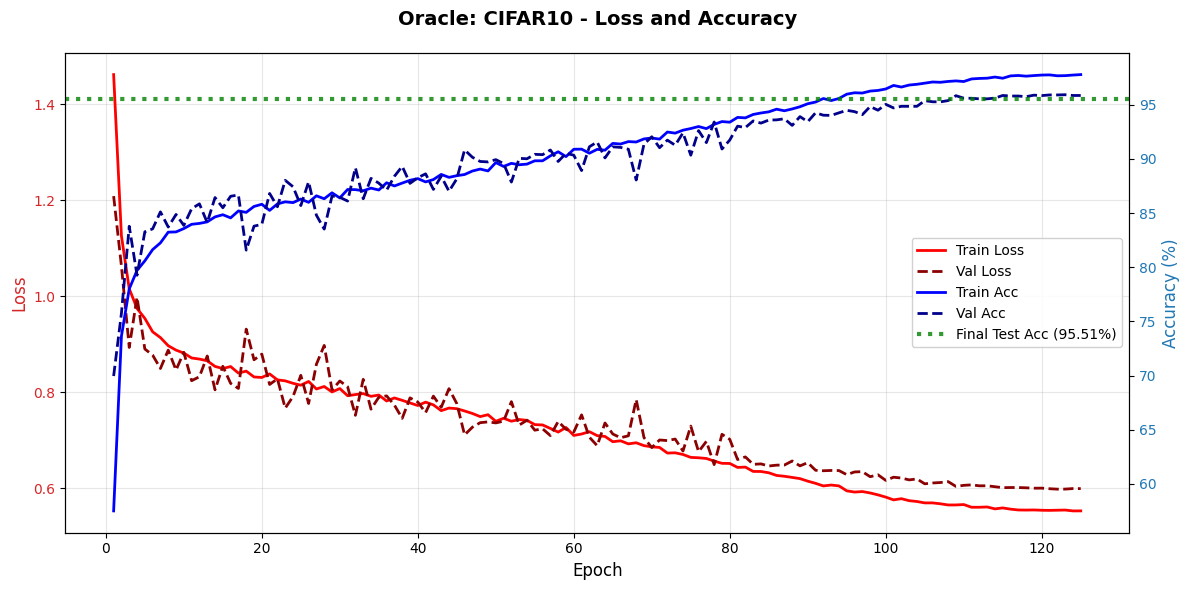

In [32]:
accuracy_plots('../logs/cifar10expt5/', "CIFAR10")

In [50]:
def plotter_v2(log_path, log_types, model_prefix, save=True, out_dir="SAE_Train_figures", formats=("pdf", "png")):
    """
    Plot training logs for multiple models and save the plots.

    Args:
        log_path (str): Path to the .pt/.pth log file (saved with torch.save).
        log_types (list[str]): Metrics to plot (e.g., ["train_loss", "val_loss"]).
        model_prefix (str): Only models starting with this prefix are plotted.
        save (bool): Whether to save the plots.
        out_dir (str): Directory to save the plots.
        formats (tuple[str]): Formats to save (default pdf + png).
    """
    logs = torch.load(log_path)
    log_map = {'avg_loss': 'Avg Loss', 
                'dead_features': 'Avg Dead Neurons'}
    
    num_logs = len(log_types)
    fig, axs = plt.subplots(1, num_logs, figsize=(6 * num_logs, 5), squeeze=False)
    
    all_handles, all_labels = [], []
    
    for idx, log_type in enumerate(log_types):
        ax = axs[0][idx]
        for model, model_logs in logs.items():
            if not model.startswith(model_prefix):
                continue
            avg_loss = model_logs[log_type]
            epochs = list(range(1, len(avg_loss) + 1))
            line, = ax.plot(epochs, avg_loss, label=model, linewidth=2)
            all_handles.append(line)
            all_labels.append(model)
        
        ax.set_xlabel("Epoch")

        log_type = log_map[log_type]
        ax.set_ylabel(log_type)
        ax.set_title(f"{log_type} Across Epochs")
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend

    # Save plots
    if save:
        os.makedirs(out_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(log_path))[0]
        out_file = os.path.join(out_dir, f"{base_name}_{model_prefix}_plots")
        for fmt in formats:
            plt.savefig(f"{out_file}.{fmt}", format=fmt, bbox_inches="tight")
            print(f"Saved plot to {out_file}.{fmt}")
    
    plt.show()


/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to SAE_Train_figures/vanilla_sae_results_vanilla_sae_plots.pdf
Saved plot to SAE_Train_figures/vanilla_sae_results_vanilla_sae_plots.png


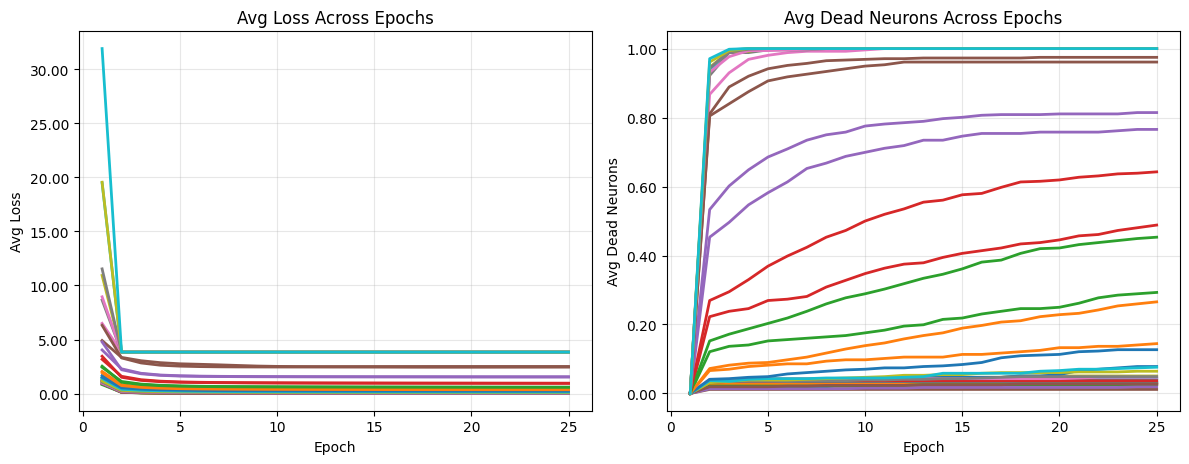

In [51]:
plotter_v2('../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results.pt', ['avg_loss', 'dead_features'], 'vanilla_sae')

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to SAE_Train_figures/top_k_sae_results_topk_sae_plots.pdf
Saved plot to SAE_Train_figures/top_k_sae_results_topk_sae_plots.png


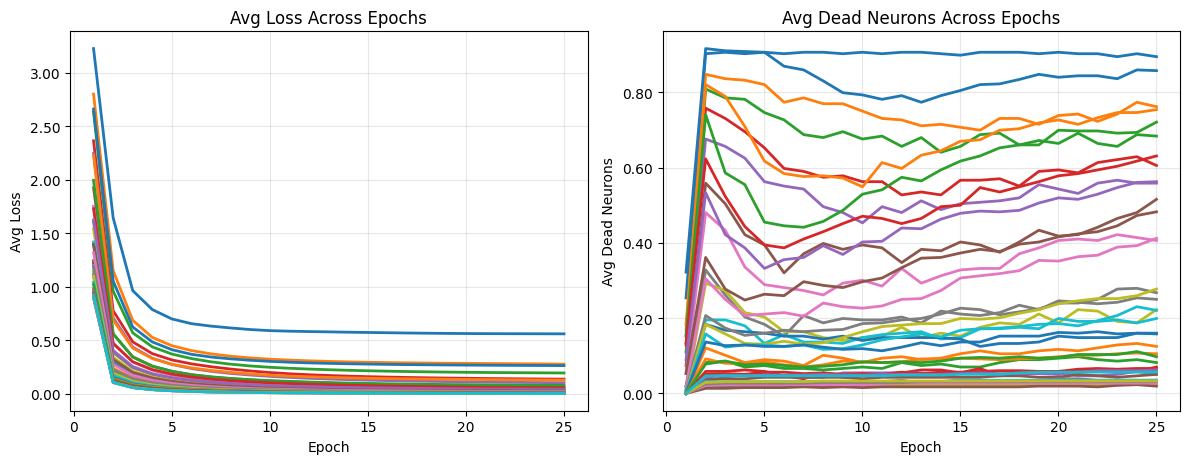

In [52]:
plotter_v2('../logs/mnist_activation/sae_train_logs/topk_sae/top_k_sae_results.pt', ['avg_loss', 'dead_features'], 'topk_sae')

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to SAE_Train_figures/vanilla_sae_results_reanim_reanim_vanilla_plots.pdf
Saved plot to SAE_Train_figures/vanilla_sae_results_reanim_reanim_vanilla_plots.png


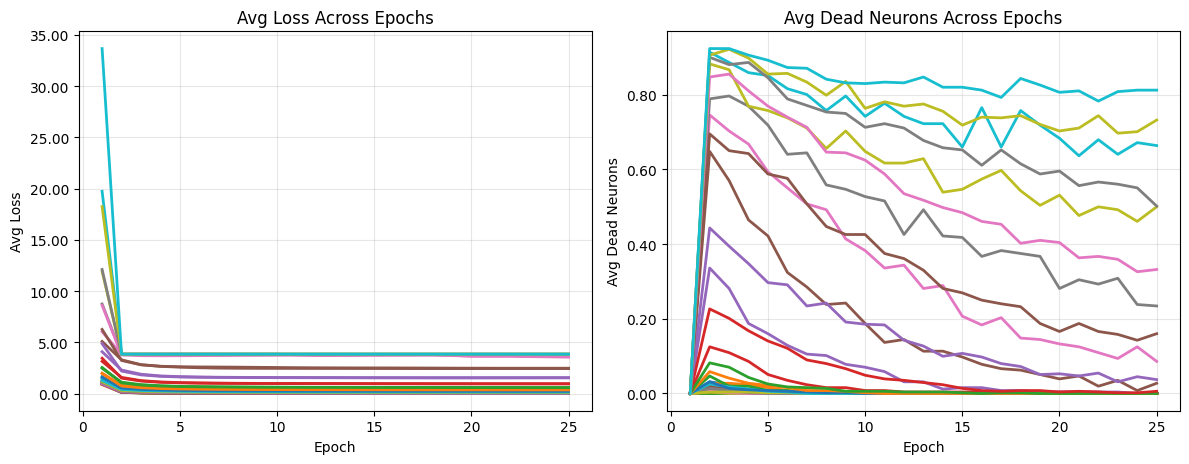

In [56]:
plotter_v2('../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results_reanim.pt', ['avg_loss', 'dead_features'], 'reanim_vanilla')

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to SAE_Train_figures/top_k_sae_results_reanim_reanim_topk_plots.pdf
Saved plot to SAE_Train_figures/top_k_sae_results_reanim_reanim_topk_plots.png


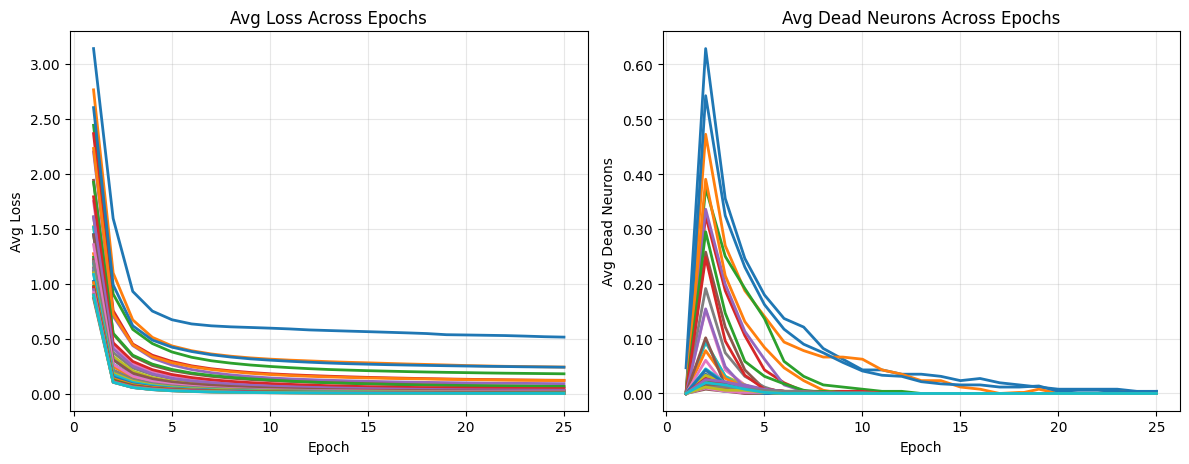

In [57]:
plotter_v2('../logs/mnist_activation/sae_train_logs/topk_sae/top_k_sae_results_reanim.pt', ['avg_loss', 'dead_features'], 'reanim_topk')

# CIFAR10

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to cifar_sae_train_figures/vanilla_sae_results_vanilla_sae_plots.pdf
Saved plot to cifar_sae_train_figures/vanilla_sae_results_vanilla_sae_plots.png


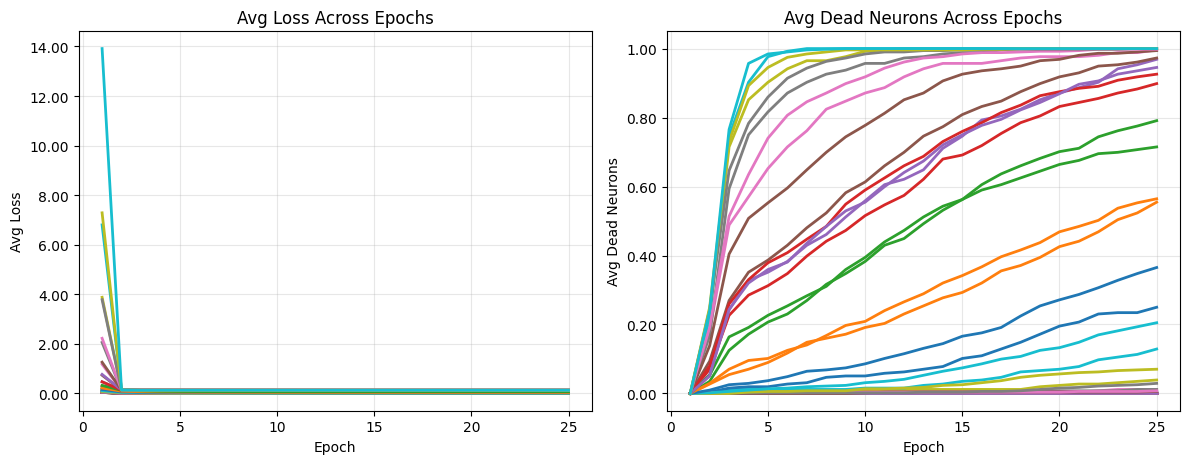

In [62]:
plotter_v2('../logs/cifar10expt5/sae_train_logs/vanilla_sae/vanilla_sae_results.pt', ['avg_loss', 'dead_features'], 'vanilla_sae', True, 'cifar_sae_train_figures')

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to cifar_sae_train_figures/vanilla_sae_results_reanim_reanim_vanilla_plots.pdf
Saved plot to cifar_sae_train_figures/vanilla_sae_results_reanim_reanim_vanilla_plots.png


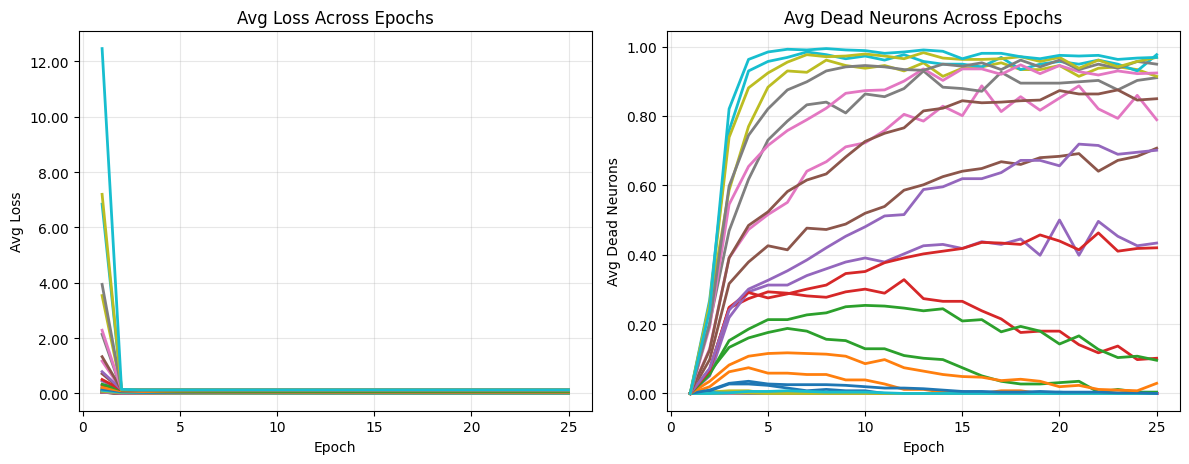

In [63]:
plotter_v2('../logs/cifar10expt5/sae_train_logs/vanilla_sae/vanilla_sae_results_reanim.pt', ['avg_loss', 'dead_features'], 'reanim_vanilla', True, 'cifar_sae_train_figures')

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to cifar_sae_train_figures/top_k_sae_results_topk_sae_plots.pdf
Saved plot to cifar_sae_train_figures/top_k_sae_results_topk_sae_plots.png


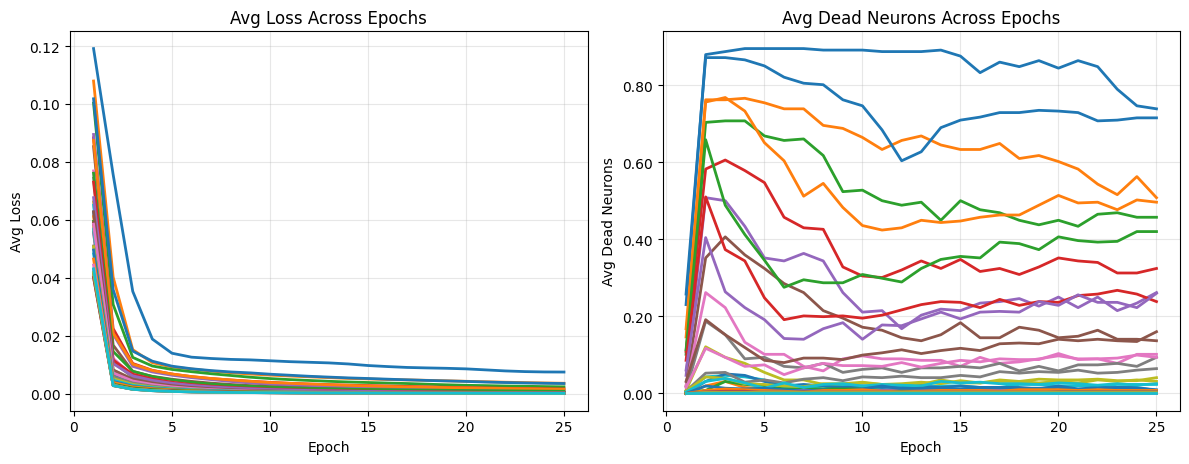

In [65]:
plotter_v2('../logs/cifar10expt5/sae_train_logs/topk_sae/top_k_sae_results.pt', 
                   ['avg_loss', 'dead_features'], 'topk_sae', True, 'cifar_sae_train_figures')

/tmp/ipykernel_1829220/378515135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(log_path)


Saved plot to cifar_sae_train_figures/top_k_sae_results_reanim_reanim_topk_plots.pdf
Saved plot to cifar_sae_train_figures/top_k_sae_results_reanim_reanim_topk_plots.png


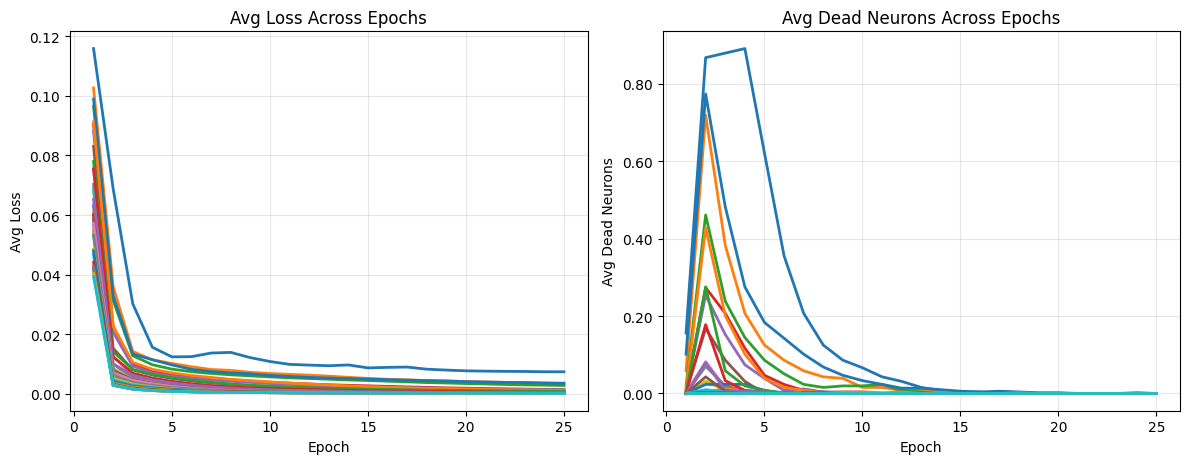

In [66]:
plotter_v2('../logs/cifar10expt5/sae_train_logs/topk_sae/top_k_sae_results_reanim.pt', 
                   ['avg_loss', 'dead_features'], 'reanim_topk', True, 'cifar_sae_train_figures')

In [11]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_digit_recovery_topk(pkl_path, out_dir="figures", save=True, formats=("pdf", "png")):
    """
    Load SAE results from a .pkl file, compute digit recovery stats,
    and plot the effect of top-k/dict_size ratio on unique digit recovery.

    Saves both raw curves and smoothed curves.

    Args:
        pkl_path (str): Path to a .pkl file containing an all_results dict.
        out_dir (str): Directory to save plots.
        save (bool): Whether to save the plots.
        formats (tuple[str]): File formats to save (default: ("pdf", "png")).
    """
    grouped_digit_counts = defaultdict(dict)

    # Step 1: Load results
    with open(pkl_path, "rb") as f:
        all_results = pickle.load(f)

    for sae_name, results in all_results.items():
        if "auc_matrix" not in results or "per_neuron_df" not in results:
            continue

        sae_name = sae_name.split("_best_loss")[0]

        try:
            # Expected format: "topk_sae_<dict_size>_<topk_val>"
            parts = sae_name.split("_")
            dict_size = int(parts[-2])
            topk_val = int(parts[-1])
            ratio = round(topk_val / dict_size, 2)  # round to 2 decimals

            # Variant excludes trailing numeric parts
            variant = "_".join(parts[:-2])

        except (ValueError, IndexError):
            continue

        auc_matrix = results["auc_matrix"]
        neuron_df = results["per_neuron_df"]

        count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
        pure_neurons = count_per_neuron[count_per_neuron == 1].index
        digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

        grouped_digit_counts[variant][ratio] = digits_represented.nunique()

    # Ensure output directory exists
    if save:
        os.makedirs(out_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(pkl_path))[0]

    plt.figure(figsize=(10, 6))
    for variant, ratio_dict in grouped_digit_counts.items():
        ratios = sorted(ratio_dict.keys())
        digits = [ratio_dict[r] for r in ratios]
        plt.plot(ratios, digits, marker="o", label=variant, linewidth=2)

    plt.xlabel("Top-k / Dictionary Size Ratio", fontsize=12)
    plt.ylabel("Number of Unique Digits Recovered (Pure Neurons)", fontsize=12)
    plt.title("Effect of Top-k/Dict Size Ratio on Digit Recovery Across SAE Variants (Raw)", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="SAE Variant")
    plt.tight_layout()

    if save:
        for fmt in formats:
            out_file = os.path.join(out_dir, f"{base_name}_digit_recovery_raw.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight")
            print(f"Saved raw plot to {out_file}")

    plt.show()


In [15]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.interpolate import make_interp_spline  # for smoothing

import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_digit_recovery_base(pkl_path, out_dir="figures", save=True, formats=("pdf", "png")):
    """
    Load SAE results from a .pkl file, compute digit recovery stats,
    and plot the effect of penalty on unique digit recovery.

    Saves both raw curves and smoothed curves.

    Args:
        pkl_path (str): Path to a .pkl file containing an all_results dict.
        out_dir (str): Directory to save plots.
        save (bool): Whether to save the plots.
        formats (tuple[str]): File formats to save (default: ("pdf", "png")).
    """
    grouped_digit_counts = defaultdict(dict)

    # Step 1: Load results
    with open(pkl_path, "rb") as f:
        all_results = pickle.load(f)

    for sae_name, results in all_results.items():
        if "auc_matrix" not in results or "per_neuron_df" not in results:
            continue

        sae_name = sae_name.split("_best_loss")[0]

        try:
            penalty = float(sae_name.split("_")[-1])
            variant = "_".join(sae_name.split("_")[:-1])
        except ValueError:
            continue

        auc_matrix = results["auc_matrix"]
        neuron_df = results["per_neuron_df"]

        count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
        pure_neurons = count_per_neuron[count_per_neuron == 1].index
        digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

        grouped_digit_counts[variant][penalty] = digits_represented.nunique()

    # Ensure output directory exists
    if save:
        os.makedirs(out_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(pkl_path))[0]

    plt.figure(figsize=(10, 6))
    for variant, penalty_dict in grouped_digit_counts.items():
        penalties = sorted(penalty_dict.keys())
        digits = [penalty_dict[p] for p in penalties]
        plt.plot(penalties, digits, marker="o", label=variant, linewidth=2)

    plt.xlabel("Penalty Value", fontsize=12)
    plt.ylabel("Number of Unique Digits Recovered (Pure Neurons)", fontsize=12)
    plt.title("Effect of Penalty on Digit Recovery Across SAE Variants (Raw)", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="SAE Variant")
    plt.tight_layout()

    # Flip only the x-axis direction
    plt.gca().invert_xaxis()

    if save:
        for fmt in formats:
            out_file = os.path.join(out_dir, f"{base_name}_digit_recovery_raw.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight")
            print(f"Saved raw plot to {out_file}")

    plt.show()


In [10]:
# plot_digit_recovery('../logs/mnist_activation/sae_train_logs/vanilla_sae/regression_results.pkl', 
#                     out_dir="mnist_regression_figures", save=True, formats=["pdf"])

Saved raw plot to mnist_regression_figures/regression_results_digit_recovery_raw.pdf


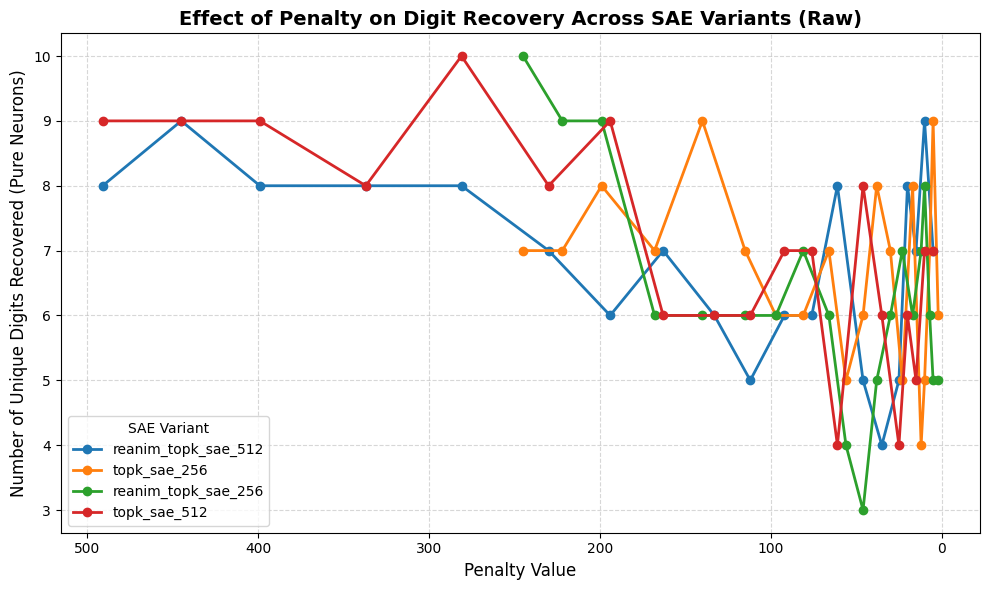

In [16]:
plot_digit_recovery_base('../logs/mnist_activation/sae_train_logs/topk_sae/regression_results.pkl', 
                    out_dir="mnist_regression_figures", save=True, formats=["pdf"])

Saved raw plot to cifar_regression_figures/regression_results_digit_recovery_raw.pdf


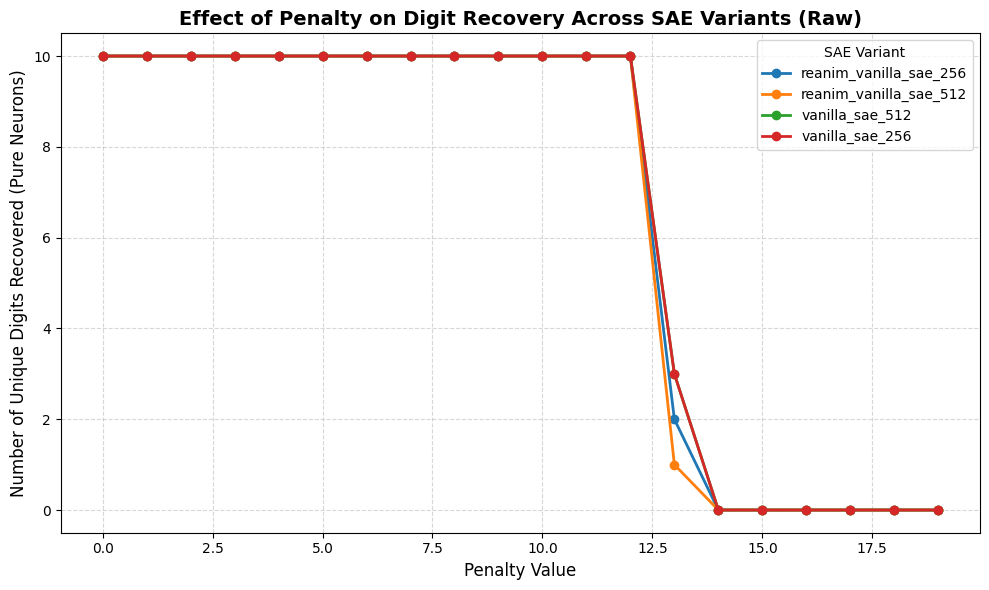

Saved smoothed plot to cifar_regression_figures/regression_results_digit_recovery_smooth.pdf


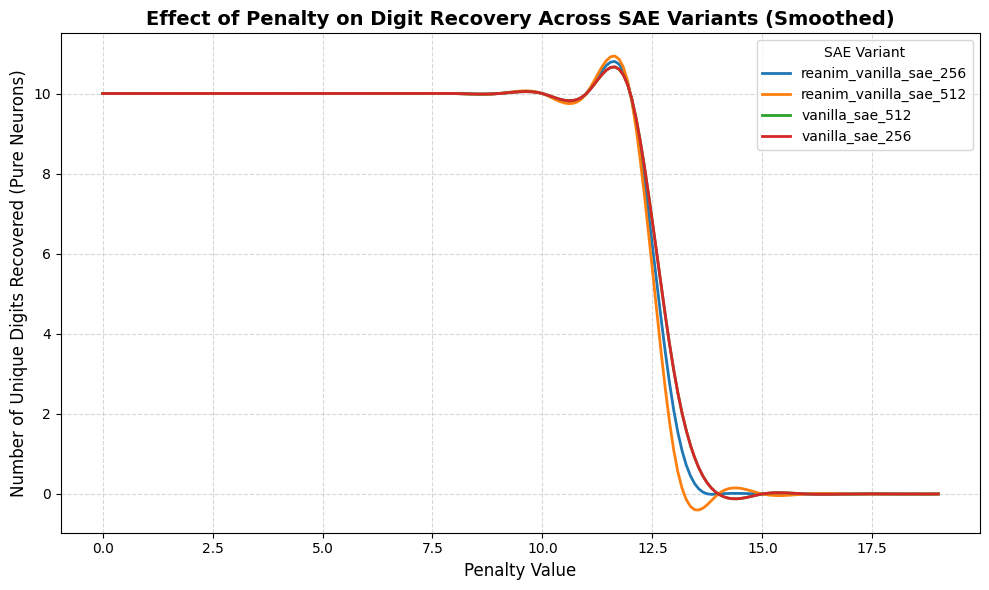

In [75]:
plot_digit_recovery('../logs/cifar10expt5/sae_train_logs/vanilla_sae/regression_results.pkl', 
                    out_dir="cifar_regression_figures", save=True, formats=["pdf"])

Saved raw plot to cifar_regression_figures/regression_results_digit_recovery_raw.pdf


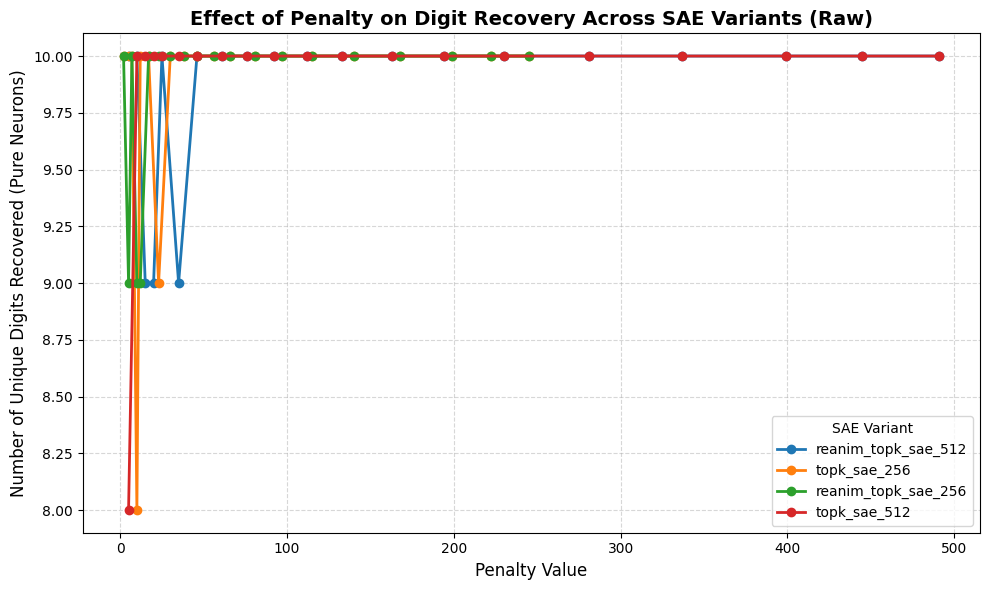

Saved smoothed plot to cifar_regression_figures/regression_results_digit_recovery_smooth.pdf


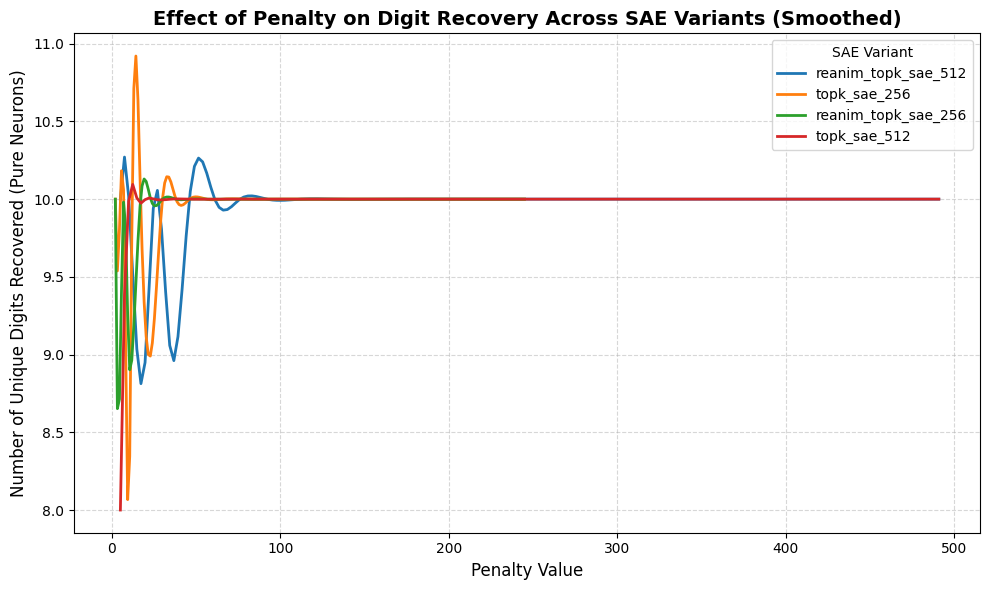

In [76]:
plot_digit_recovery('../logs/cifar10expt5/sae_train_logs/topk_sae/regression_results.pkl', 
                    out_dir="cifar_regression_figures", save=True, formats=["pdf"])

In [87]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

def parse_sae_name(sae_name, sae_prefix='vanilla'):
    """
    Parse SAE name to extract configuration parameters.

    Args:
        sae_name (str): SAE name string.
        sae_prefix (str): Expected SAE prefix in the name ('vanilla', 'topk', etc.).

    Returns:
        tuple: (has_reanim: bool, dict_size: int or None, penalty: int or None)
    """
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]  # remove reanim_ prefix

    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == sae_prefix and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return has_reanim, None, None


def plot_encoder_decoder_stable_rank(all_stable_rank_results, 
                                     sae_prefix='vanilla',
                                     figsize=(15, 10), 
                                     rank_type='stable_rank',
                                     use_frobenius=True,
                                     threshold=0.01,
                                     save=False,
                                     out_path=None):
    """
    Plot encoder and decoder stable/effective ranks vs penalty.
    
    Args:
        all_stable_rank_results: Dictionary of SAE results
        sae_prefix: SAE type prefix to parse names ('vanilla', 'topk', etc.)
        figsize: Figure size tuple
        rank_type: 'stable_rank', 'effective_rank', or 'both'
        use_frobenius: Whether to use frobenius-based calculation
        threshold: Threshold value if not using frobenius
        save: Whether to save the figure to disk
        out_path: Path to save the figure (PDF)
    """
    # Group data by SAE configuration
    grouped_data = {}
    for sae_name, sae_results in all_stable_rank_results.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name, sae_prefix=sae_prefix)
        if dict_size is None or penalty is None:
            continue
        
        key = (has_reanim, dict_size)
        if key not in grouped_data:
            grouped_data[key] = {
                'penalties': [], 
                'enc_stable_ranks': [], 
                'dec_stable_ranks': [],
                'enc_effective_ranks': [], 
                'dec_effective_ranks': [],
                'enc_total_ranks': [], 
                'dec_total_ranks': []
            }
        
        # Extract rank values
        if use_frobenius:
            enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
            dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
        else:
            threshold_key = f'threshold_{threshold}'
            enc_data = sae_results.get('encoder_analysis', {}).get(threshold_key, {})
            dec_data = sae_results.get('decoder_analysis', {}).get(threshold_key, {})

        # Get rank values
        enc_stable = enc_data.get('stable_rank')
        dec_stable = dec_data.get('stable_rank')
        enc_effective = enc_data.get('effective_rank')
        dec_effective = dec_data.get('effective_rank')
        enc_total = enc_data.get('total_rank')
        dec_total = dec_data.get('total_rank')

        if enc_stable is not None and dec_stable is not None:
            grouped_data[key]['penalties'].append(penalty)
            grouped_data[key]['enc_stable_ranks'].append(enc_stable)
            grouped_data[key]['dec_stable_ranks'].append(dec_stable)
            grouped_data[key]['enc_effective_ranks'].append(enc_effective if enc_effective else 0)
            grouped_data[key]['dec_effective_ranks'].append(dec_effective if dec_effective else 0)
            grouped_data[key]['enc_total_ranks'].append(enc_total if enc_total else 0)
            grouped_data[key]['dec_total_ranks'].append(dec_total if dec_total else 0)

    # --- Plotting ---
    if rank_type == 'both':
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Encoder & Decoder Rank Analysis vs Penalty', fontsize=16, fontweight='bold')
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        rank_name = 'Stable' if rank_type == 'stable_rank' else 'Effective'
        fig.suptitle(f'Encoder & Decoder {rank_name} Rank vs Penalty', fontsize=14, fontweight='bold')

    colors = plt.cm.tab10(np.linspace(0, 1, len(grouped_data)))

    for i, ((has_reanim, dict_size), data) in enumerate(grouped_data.items()):
        penalties = np.array(data['penalties'])
        sort_idx = np.argsort(penalties)
        penalties = penalties[sort_idx]
        label = f"{'Reanim' if has_reanim else 'Vanilla'} SAE {dict_size}"
        color = colors[i]

        if rank_type == 'both':
            enc_stable = np.array(data['enc_stable_ranks'])[sort_idx]
            dec_stable = np.array(data['dec_stable_ranks'])[sort_idx]
            enc_effective = np.array(data['enc_effective_ranks'])[sort_idx]
            dec_effective = np.array(data['dec_effective_ranks'])[sort_idx]

            axes[0].plot(penalties, enc_stable, marker='o', label=label, color=color)
            axes[1].plot(penalties, dec_stable, marker='s', label=label, color=color)

            if np.any(enc_effective > 0):
                axes[2].plot(penalties, enc_effective, marker='^', label=label, color=color)
            if np.any(dec_effective > 0):
                axes[3].plot(penalties, dec_effective, marker='v', label=label, color=color)

        else:
            if rank_type == 'stable_rank':
                enc_ranks = np.array(data['enc_stable_ranks'])[sort_idx]
                dec_ranks = np.array(data['dec_stable_ranks'])[sort_idx]
                marker_enc, marker_dec = 'o', 's'
            else:
                enc_ranks = np.array(data['enc_effective_ranks'])[sort_idx]
                dec_ranks = np.array(data['dec_effective_ranks'])[sort_idx]
                marker_enc, marker_dec = '^', 'v'

                if not np.any(enc_ranks > 0) or not np.any(dec_ranks > 0):
                    continue

            axes[0].plot(penalties, enc_ranks, marker=marker_enc, label=label, color=color)
            axes[1].plot(penalties, dec_ranks, marker=marker_dec, label=label, color=color)

    # Configure axes
    if rank_type == 'both':
        titles = ["Encoder Stable Rank", "Decoder Stable Rank", 
                  "Encoder Effective Rank", "Decoder Effective Rank"]
        for i, (ax, title) in enumerate(zip(axes, titles)):
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel("Penalty")
            ax.set_ylabel("Rank")
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    else:
        rank_name = 'Stable' if rank_type == 'stable_rank' else 'Effective'
        axes[0].set_title(f"Encoder {rank_name} Rank", fontweight='bold')
        axes[1].set_title(f"Decoder {rank_name} Rank", fontweight='bold')
        for ax in axes:
            ax.set_xlabel("Penalty")
            ax.set_ylabel(f"{rank_name} Rank")
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save figure
    if save and out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, format='pdf', bbox_inches='tight')
        print(f"Saved figure to {out_path}")

    plt.show()
    return fig


In [97]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

def parse_sae_name(sae_name, sae_prefix='vanilla'):
    """
    Parse SAE name to extract configuration parameters.

    Args:
        sae_name (str): SAE name string.
        sae_prefix (str): Expected SAE prefix in the name ('vanilla', 'topk', etc.).

    Returns:
        tuple: (has_reanim: bool, dict_size: int or None, penalty: int or None)
    """
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]  # remove reanim_ prefix

    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == sae_prefix and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return has_reanim, None, None


def plot_encoder_decoder_stable_rank(all_stable_rank_results, 
                                     sae_prefix='vanilla',
                                     figsize=(12, 6), 
                                     use_frobenius=True,
                                     threshold=0.01,
                                     save=False,
                                     out_path=None):
    """
    Plot encoder and decoder stable ranks vs penalty.
    
    Args:
        all_stable_rank_results: Dictionary of SAE results
        sae_prefix: SAE type prefix to parse names ('vanilla', 'topk', etc.)
        figsize: Figure size tuple
        use_frobenius: Whether to use frobenius-based calculation
        threshold: Threshold value if not using frobenius
        save: Whether to save the figure to disk
        out_path: Path to save the figure (PDF)
    """
    # Group data by SAE configuration
    grouped_data = {}
    for sae_name, sae_results in all_stable_rank_results.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name, sae_prefix=sae_prefix)
        if dict_size is None or penalty is None:
            continue
        
        key = (has_reanim, dict_size)
        if key not in grouped_data:
            grouped_data[key] = {
                'penalties': [], 
                'enc_stable_ranks': [], 
                'dec_stable_ranks': []
            }
        
        # Extract rank values
        if use_frobenius:
            enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
            dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
        else:
            threshold_key = f'threshold_{threshold}'
            enc_data = sae_results.get('encoder_analysis', {}).get(threshold_key, {})
            dec_data = sae_results.get('decoder_analysis', {}).get(threshold_key, {})

        # Get stable rank values
        enc_stable = enc_data.get('stable_rank')
        dec_stable = dec_data.get('stable_rank')

        if enc_stable is not None and dec_stable is not None:
            grouped_data[key]['penalties'].append(penalty)
            grouped_data[key]['enc_stable_ranks'].append(enc_stable)
            grouped_data[key]['dec_stable_ranks'].append(dec_stable)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Encoder & Decoder Stable Rank vs Penalty', fontsize=14, fontweight='bold')
    
    # Ensure axes is always a 1D array for consistent indexing
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    elif axes.ndim > 1:
        axes = axes.flatten()

    colors = plt.cm.tab10(np.linspace(0, 1, len(grouped_data)))

    for i, ((has_reanim, dict_size), data) in enumerate(grouped_data.items()):
        penalties = np.array(data['penalties'])
        sort_idx = np.argsort(penalties)
        penalties = penalties[sort_idx]
        label = f"{'Reanim' if has_reanim else 'Vanilla'} SAE {dict_size}"
        color = colors[i]

        enc_stable = np.array(data['enc_stable_ranks'])[sort_idx]
        dec_stable = np.array(data['dec_stable_ranks'])[sort_idx]

        axes[0].plot(penalties, enc_stable, marker='o', label=label, color=color)
        axes[1].plot(penalties, dec_stable, marker='s', label=label, color=color)

    # Configure axes
    axes[0].set_title("Encoder Stable Rank", fontweight='bold')
    axes[1].set_title("Decoder Stable Rank", fontweight='bold')
    
    for ax in axes:
        ax.set_xlabel("Penalty")
        ax.set_ylabel("Stable Rank")
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save figure
    if save and out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, format='pdf', bbox_inches='tight')
        print(f"Saved figure to {out_path}")

    plt.show()
    return fig

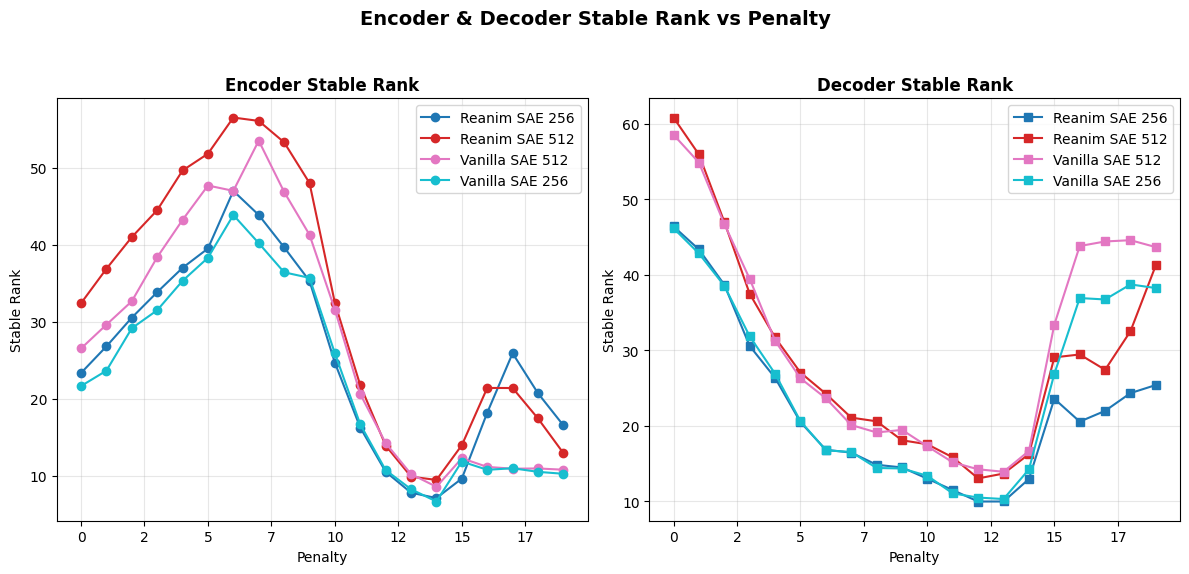

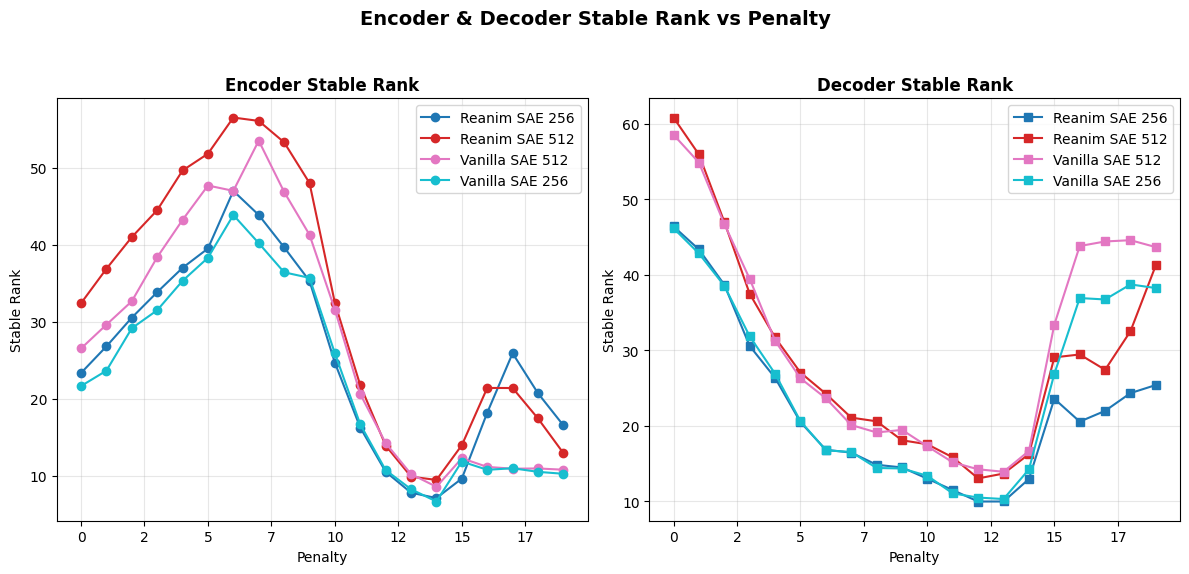

In [98]:
with open('../logs/mnist_activation/sae_train_logs/vanilla_sae/stable_rank_results.pkl', 'rb') as f:
    stable_rank_data = pickle.load(f)

plot_encoder_decoder_stable_rank(stable_rank_data)

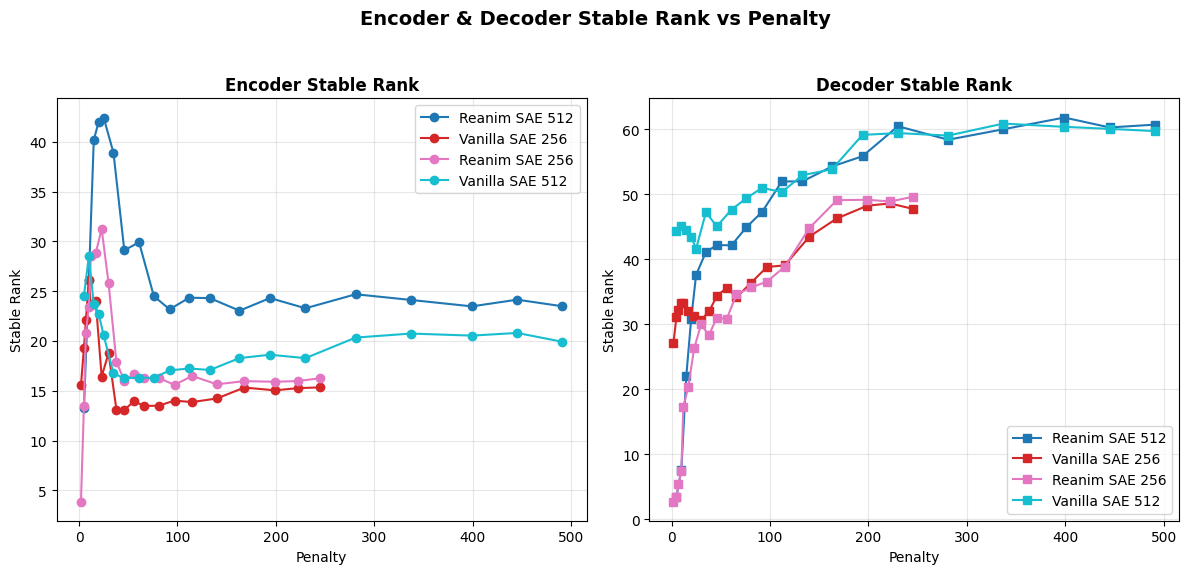

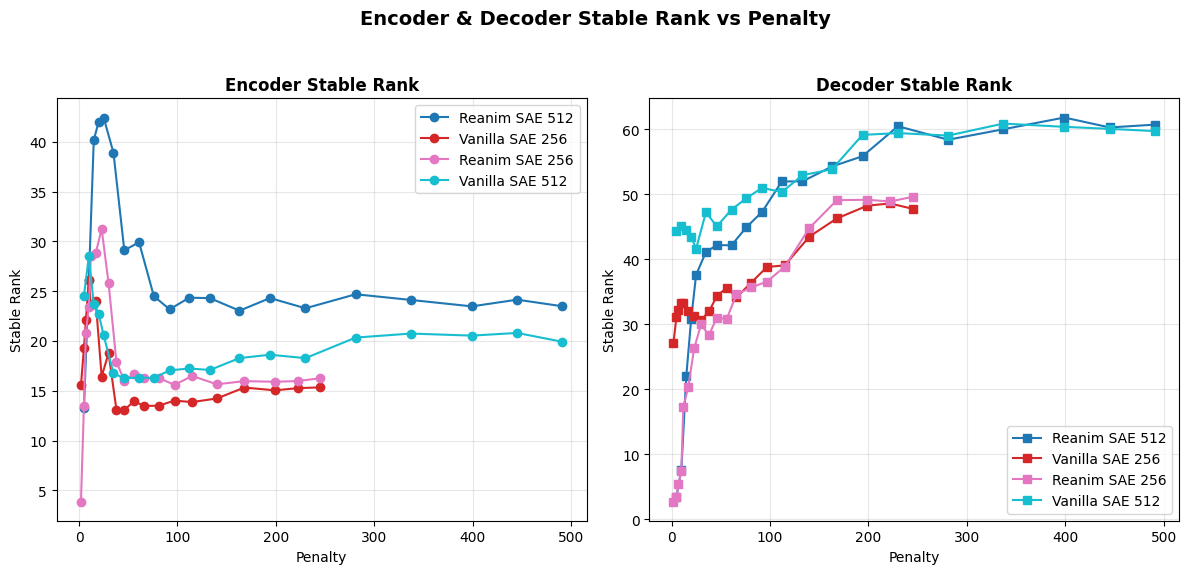

In [96]:
with open('../logs/mnist_activation/sae_train_logs/topk_sae/stable_rank_results.pkl', 'rb') as f:
    stable_rank_data = pickle.load(f)

plot_encoder_decoder_stable_rank(stable_rank_data, sae_prefix='topk')

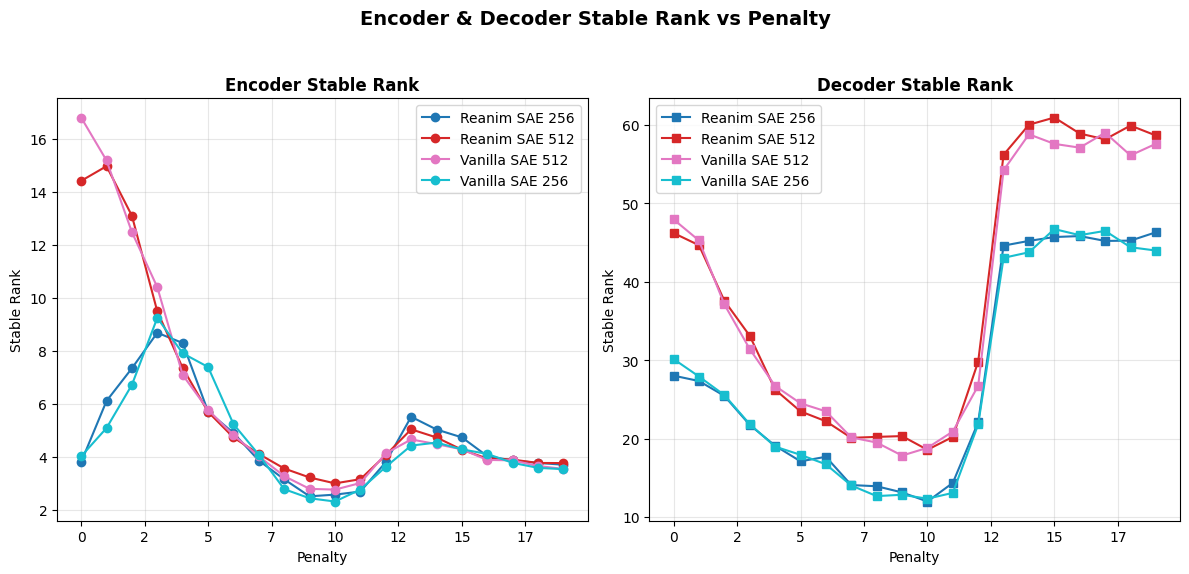

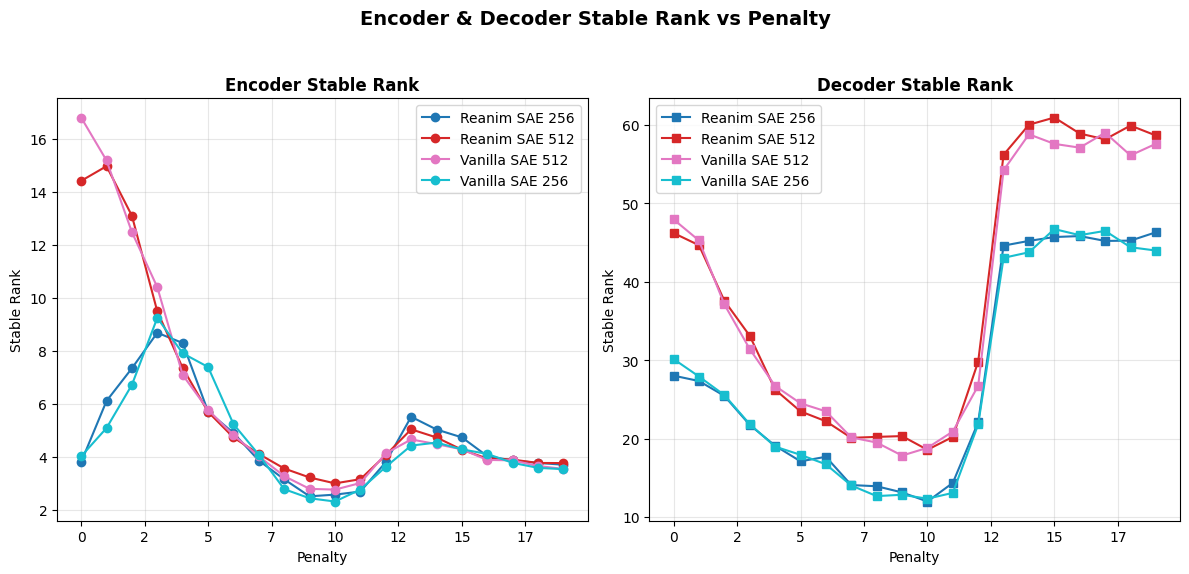

In [101]:
with open('../logs/cifar10expt5/sae_train_logs/vanilla_sae/stable_rank_results.pkl', 'rb') as f:
    stable_rank_data = pickle.load(f)

plot_encoder_decoder_stable_rank(stable_rank_data)

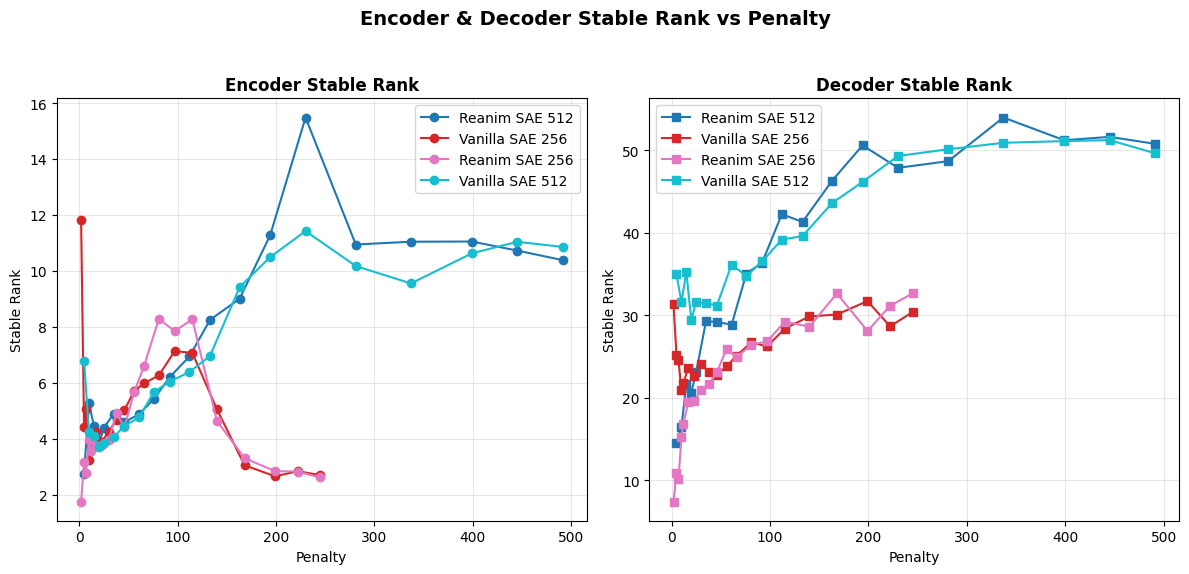

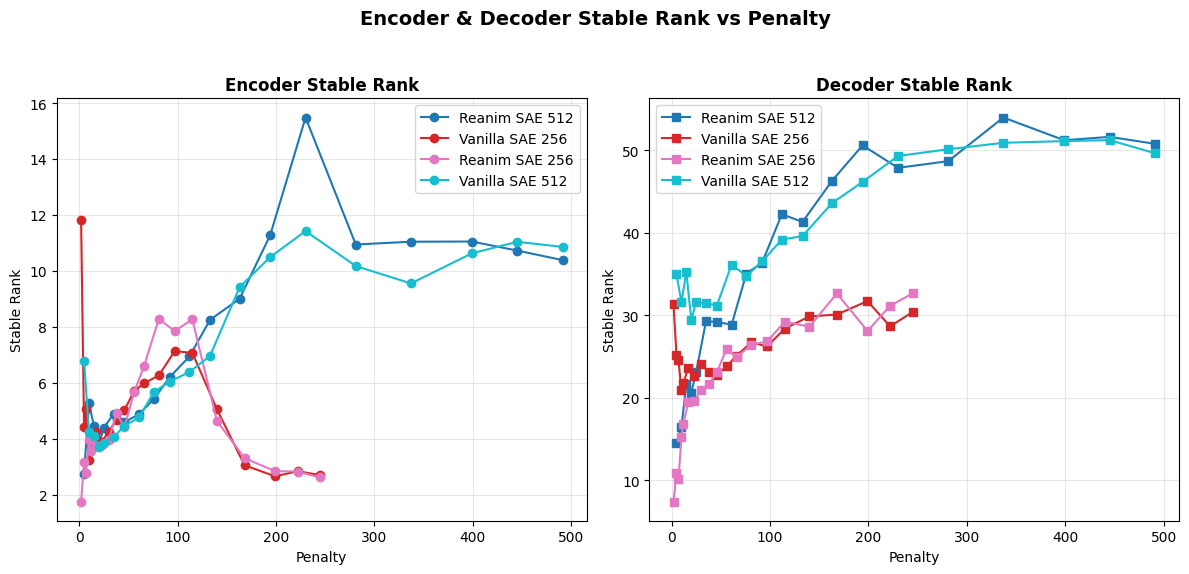

In [99]:
with open('../logs/cifar10expt5/sae_train_logs/topk_sae/stable_rank_results.pkl', 'rb') as f:
    stable_rank_data = pickle.load(f)

plot_encoder_decoder_stable_rank(stable_rank_data, sae_prefix='topk')

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
from scipy.interpolate import make_interp_spline


def plot_digit_recovery(pkl_path, log_path=None, additional_log_paths=None, out_dir="figures", save=True, formats=("pdf", "png")):
    """
    Load SAE results from a .pkl file, compute digit recovery stats,
    and plot the effect of penalty on unique digit recovery.
    Optionally adds final loss values from training logs.

    Saves both raw curves and smoothed curves.

    Args:
        pkl_path (str): Path to a .pkl file containing an all_results dict.
        log_path (str): Optional path to the .pt/.pth log file with training losses.
        additional_log_paths (list[str]): Optional list of additional log file paths to merge.
        out_dir (str): Directory to save plots.
        save (bool): Whether to save the plots.
        formats (tuple[str]): File formats to save (default: ("pdf", "png")).
    """
    grouped_digit_counts = defaultdict(dict)
    grouped_final_losses = defaultdict(dict)

    # Step 1: Load results
    with open(pkl_path, "rb") as f:
        all_results = pickle.load(f)

    # Step 2: Load training logs if provided
    training_logs = {}
    if log_path:
        training_logs.update(torch.load(log_path))
    
    # Step 3: Load additional log files and merge them
    if additional_log_paths:
        for add_log_path in additional_log_paths:
            additional_logs = torch.load(add_log_path)
            training_logs.update(additional_logs)

    for sae_name, results in all_results.items():
        if "auc_matrix" not in results or "per_neuron_df" not in results:
            continue

        # Clean up sae_name - remove _best_loss suffix if present
        sae_name_clean = sae_name.replace("_best_loss", "")

        try:
            penalty = float(sae_name_clean.split("_")[-1])
            variant = "_".join(sae_name_clean.split("_")[:-1])
        except ValueError:
            continue

        auc_matrix = results["auc_matrix"]
        neuron_df = results["per_neuron_df"]

        count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
        pure_neurons = count_per_neuron[count_per_neuron == 1].index
        digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

        grouped_digit_counts[variant][penalty] = digits_represented.nunique()

        # Get final loss if training logs are available
        if training_logs:
            # Match by the cleaned name (without _best_loss)
            if sae_name_clean in training_logs:
                final_loss = training_logs[sae_name_clean]['avg_loss'][-1]
                grouped_final_losses[variant][penalty] = final_loss

    # Ensure output directory exists
    if save:
        os.makedirs(out_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(pkl_path))[0]

    # --- Plot: Raw curves only ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(grouped_digit_counts)))
    
    lines1 = []
    labels1 = []
    for idx, (variant, penalty_dict) in enumerate(grouped_digit_counts.items()):
        penalties = sorted(penalty_dict.keys())
        digits = [penalty_dict[p] for p in penalties]
        line, = ax1.plot(penalties, digits, marker="o", label=variant, linewidth=2, color=colors[idx])
        lines1.append(line)
        labels1.append(variant)

    ax1.set_xlabel("Penalty Value", fontsize=12)
    ax1.set_ylabel("Number of Unique Digits Recovered (Pure Neurons)", fontsize=12, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Add secondary y-axis for loss if available
    lines2 = []
    labels2 = []
    if grouped_final_losses:
        ax2 = ax1.twinx()
        
        for idx, (variant, penalty_dict) in enumerate(grouped_final_losses.items()):
            penalties = sorted(penalty_dict.keys())
            losses = [penalty_dict[p] for p in penalties]
            line, = ax2.plot(penalties, losses, marker="s", linestyle="--", alpha=0.6, 
                    linewidth=1.5, color=colors[idx], label=f"{variant} (loss)")
            lines2.append(line)
            labels2.append(f"{variant} (loss)")
        
        ax2.set_ylabel("Final Training Loss", fontsize=12, color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

    # Combined legend at the bottom
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_lines, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
               ncol=3, frameon=True, fontsize=10)

    plt.title("Effect of Penalty on Digit Recovery Across SAE Variants", 
             fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    if save:
        for fmt in formats:
            out_file = os.path.join(out_dir, f"{base_name}_digit_recovery.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight")
            print(f"Saved plot to {out_file}")

    plt.show()

/tmp/ipykernel_583529/59864667.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  additional_logs = torch.load(add_log_path)


Saved plot to test_figures/regression_results_digit_recovery.pdf


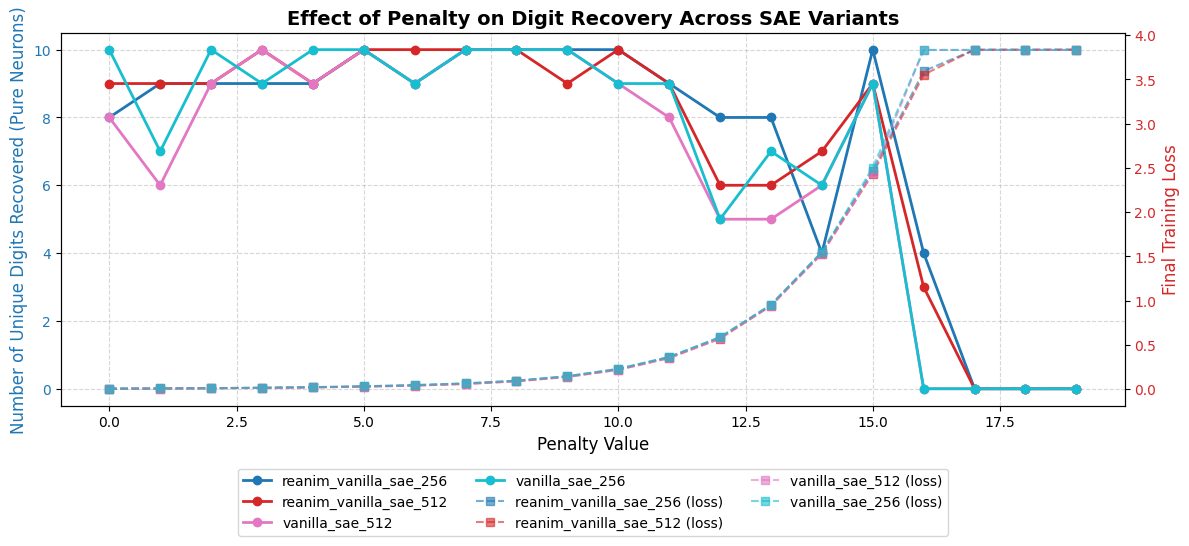

In [18]:
plot_digit_recovery(pkl_path='../logs/mnist_activation/sae_train_logs/vanilla_sae/regression_results.pkl', 
                    additional_log_paths=["../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results.pt",
                                          "../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results_reanim.pt"],
                    out_dir="test_figures", save=True, formats=["pdf"])

In [ ]:
plot_digit_recovery(pkl_path='../logs/mnist_activation/sae_train_logs/vanilla_sae/regression_results.pkl', 
                    additional_log_paths=["../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results.pt",
                                          "../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results_reanim.pt"],
                    out_dir="test_figures", save=True, formats=["pdf"])

/tmp/ipykernel_1069954/59864667.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  additional_logs = torch.load(add_log_path)


Saved plot to test_figures/regression_results_digit_recovery.pdf


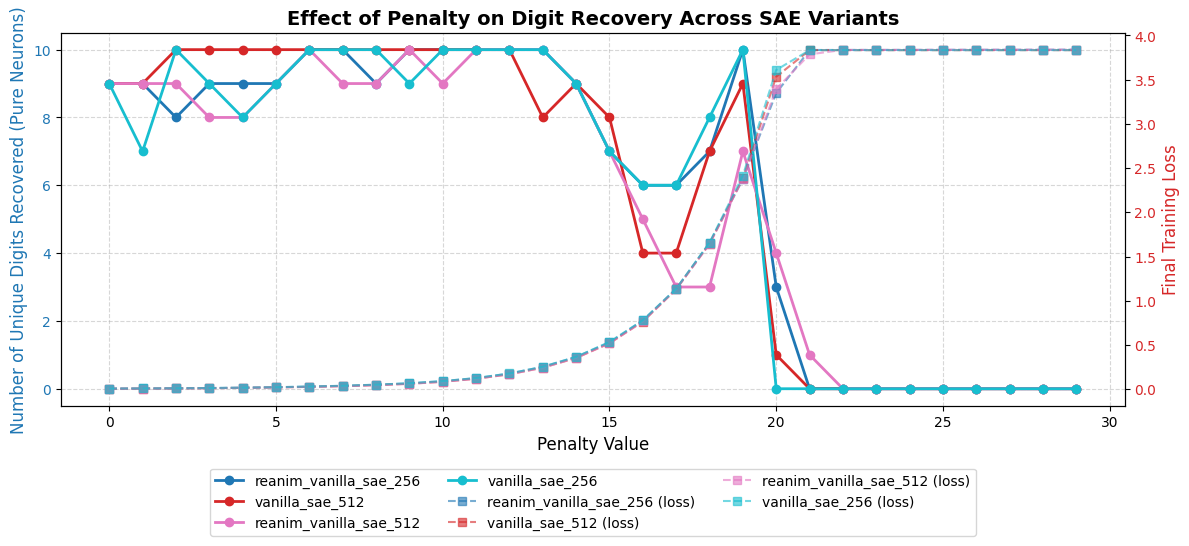

In [4]:
plot_digit_recovery(pkl_path='../logs/mnist_activation/sae_train_logs_l1_v1/vanilla_sae/regression_results.pkl', 
                    additional_log_paths=["../logs/mnist_activation/sae_train_logs_l1_v1/vanilla_sae/vanilla_sae_results.pt",
                                          "../logs/mnist_activation/sae_train_logs_l1_v1/vanilla_sae/vanilla_sae_results_reanim.pt"],
                    out_dir="test_figures", save=True, formats=["pdf"])

In [28]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
from scipy.interpolate import make_interp_spline


def plot_digit_recovery_topk_both(pkl_path, log_path=None, additional_log_paths=None, out_dir="figures", save=True, formats=("pdf", "png")):
    """
    Load SAE results from a .pkl file, compute digit recovery stats,
    and plot the effect of penalty on unique digit recovery.
    Optionally adds final loss values from training logs.

    Saves both raw curves and smoothed curves.

    Args:
        pkl_path (str): Path to a .pkl file containing an all_results dict.
        log_path (str): Optional path to the .pt/.pth log file with training losses.
        additional_log_paths (list[str]): Optional list of additional log file paths to merge.
        out_dir (str): Directory to save plots.
        save (bool): Whether to save the plots.
        formats (tuple[str]): File formats to save (default: ("pdf", "png")).
    """
    grouped_digit_counts = defaultdict(dict)
    grouped_final_losses = defaultdict(dict)

    # Step 1: Load results
    with open(pkl_path, "rb") as f:
        all_results = pickle.load(f)

    # Step 2: Load training logs if provided
    training_logs = {}
    if log_path:
        training_logs.update(torch.load(log_path))
    
    # Step 3: Load additional log files and merge them
    if additional_log_paths:
        for add_log_path in additional_log_paths:
            additional_logs = torch.load(add_log_path)
            training_logs.update(additional_logs)

    for sae_name, results in all_results.items():
        if "auc_matrix" not in results or "per_neuron_df" not in results:
            continue

        # Clean up sae_name - remove _best_loss suffix if present
        sae_name_clean = sae_name.replace("_best_loss", "")

        try:
            penalty = float(sae_name_clean.split("_")[-1])
            variant = "_".join(sae_name_clean.split("_")[:-1])
        except ValueError:
            continue

        auc_matrix = results["auc_matrix"]
        neuron_df = results["per_neuron_df"]

        count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
        pure_neurons = count_per_neuron[count_per_neuron == 1].index
        digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

        grouped_digit_counts[variant][penalty] = digits_represented.nunique()

        # Get final loss if training logs are available
        if training_logs:
            # Match by the cleaned name (without _best_loss)
            if sae_name_clean in training_logs:
                final_loss = training_logs[sae_name_clean]['avg_loss'][-1]
                grouped_final_losses[variant][penalty] = final_loss

    # Ensure output directory exists
    if save:
        os.makedirs(out_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(pkl_path))[0]

    # --- Plot: Raw curves only ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(grouped_digit_counts)))
    
    lines1 = []
    labels1 = []
    for idx, (variant, penalty_dict) in enumerate(grouped_digit_counts.items()):
        penalties = sorted(penalty_dict.keys())
        digits = [penalty_dict[p] for p in penalties]
        line, = ax1.plot(penalties, digits, marker="o", label=variant, linewidth=2, color=colors[idx])
        lines1.append(line)
        labels1.append(variant)

    ax1.set_xlabel("Penalty Value", fontsize=12)
    ax1.set_ylabel("Number of Unique Digits Recovered (Pure Neurons)", fontsize=12, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Flip the x-axis so larger penalties are on the left
    ax1.invert_xaxis()

    # Add secondary y-axis for loss if available
    lines2 = []
    labels2 = []
    if grouped_final_losses:
        ax2 = ax1.twinx()
        
        for idx, (variant, penalty_dict) in enumerate(grouped_final_losses.items()):
            penalties = sorted(penalty_dict.keys())
            losses = [penalty_dict[p] for p in penalties]
            line, = ax2.plot(penalties, losses, marker="s", linestyle="--", alpha=0.6, 
                    linewidth=1.5, color=colors[idx], label=f"{variant} (loss)")
            lines2.append(line)
            labels2.append(f"{variant} (loss)")
        
        ax2.set_ylabel("Final Training Loss", fontsize=12, color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        # REMOVED: ax2.invert_xaxis() - this was re-inverting the already inverted axis!

    # Combined legend at the bottom
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_lines, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
               ncol=3, frameon=True, fontsize=10)

    plt.title("Effect of Penalty on Digit Recovery Across SAE Variants", 
             fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    if save:
        for fmt in formats:
            out_file = os.path.join(out_dir, f"{base_name}_digit_recovery.{fmt}")
            plt.savefig(out_file, format=fmt, bbox_inches="tight")
            print(f"Saved plot to {out_file}")

    plt.show()

In [ ]:
plot_digit_recovery(pkl_path='../logs/mnist_activation/sae_train_logs/vanilla_sae/regression_results.pkl', 
                    additional_log_paths=["../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results.pt",
                                          "../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results_reanim.pt"],
                    out_dir="test_figures", save=True, formats=["pdf"])

/tmp/ipykernel_1069954/59864667.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  additional_logs = torch.load(add_log_path)


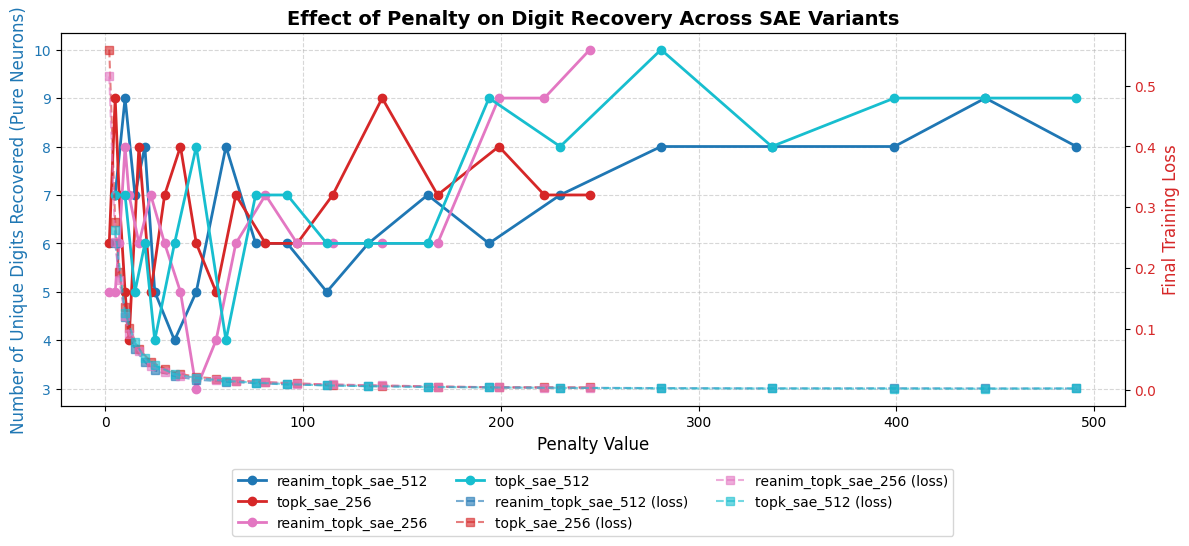

In [31]:
plot_digit_recovery(pkl_path='../logs/mnist_activation/sae_train_logs/topk_sae/regression_results.pkl', 
                    additional_log_paths=["../logs/mnist_activation/sae_train_logs/topk_sae/top_k_sae_results.pt",
                                          "../logs/mnist_activation/sae_train_logs/topk_sae/top_k_sae_results_reanim.pt"],
                    out_dir="test_figures", save=False, formats=["pdf"])

In [ ]:
plot_digit_recovery(pkl_path='../logs/mnist_activation/sae_train_logs/vanilla_sae/regression_results.pkl', 
                    additional_log_paths=["../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results.pt",
                                          "../logs/mnist_activation/sae_train_logs/vanilla_sae/vanilla_sae_results_reanim.pt"],
                    out_dir="test_figures", save=True, formats=["pdf"])